In [1]:
import numpy as np
import pickle
import os

from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings


os.chdir("groupshift-model")
from groupshift_model import *

# Run single simulations

In [ ]:
# Model parameters
num_nodes = 1000
num_groups = 2
timesteps = 10000
dims = 1                # Opinion dimensions (may not work)
lowvalence = 0          # Low end of opinion values
highvalence = 100       # High end of opinion values
temp = 100              # Num active nodes per timestep
init_method = "initgauss"
ingroup_sample_size=50
outgroup_sample_size=50
# Function used for sampling method
SCOPE = AsymmetricSample(ingroup_sample_size, outgroup_sample_size, "extremity")
# Function used for Attraction effect
GLEAN = Attract(aWidth = 4.0, aAmp = 0.2)
# Function used for Repulsion effect
SHIFT = Repulse(rWidth = 4.0, rAmp = 1.0)

# Dummy values for parameters otherwise used in paralellization
simnum = 1 # This is just for filename purposes
offset_simnum= np.random.randint(10000) # This is used as the seed
foldername = "//"
G = np.array([])
N = np.array([])
N_adj = np.array([])
C = np.array([])

simulation = GroupshiftSim(G,
                           N,
                           N_adj,
                           C,
                           num_nodes,
                           dims,
                           num_groups,
                           timesteps,
                           (lowvalence, highvalence),
                           offset_simnum,
                           temp,
                           init_method,
                           SCOPE,
                           GLEAN,
                           SHIFT,
                           folder = foldername,
                           filename = f'simulation{simnum}')

In [3]:
simulation.initializeSim()
simulation.run_simulation()

In [4]:
simulation.plot_group_values()
simulation.plot_indiv_values(0)

# Load dataset

In [6]:
import pandas as pd
import numpy as np

# -----------------------------
# Load base dataset
# -----------------------------

df = pd.read_csv("/l/nx/data/groupshift/simdata/results_2026_02_20_13_48.csv")
df.reset_index(drop=True, inplace=True)

LOW_POLE  = 0
HIGH_POLE = 100
MIDPOINT  = (LOW_POLE + HIGH_POLE) / 2

# -----------------------------
# Pole labeling (absolute)
# -----------------------------

# df["pole"] = np.where(df["true_mean"] < MIDPOINT, "low", "high")
# df["pole_sign"] = np.where(df["pole"] == "high", 1, -1)

# -----------------------------
# Pole labeling (relative)
# -----------------------------

df["rank_within_sim"] = (
    df
    .groupby(["init_type", "sample_method", "simnum"])["true_mean"]
    .rank(method="first")
)

df["pole"] = np.where(
    df["rank_within_sim"] == 1,
    "low",
    "high"
)

df["pole_sign"] = np.where(df["pole"] == "high", 1, -1)

# -----------------------------
# Signed ingroup misperception
# -----------------------------

df["signed_discrepancy"] = (
    df["pole_sign"] * (df["percept_fin"] - df["true_mean"])
)

# -----------------------------
# Reorder columns for readability
# -----------------------------

df.loc[:, ["init_type", 
           "sample_method", 
           "simnum", 
           "GroupID", 
           "group_size_init", 
           "group_size_fin", 
           "true_mean", 
           "true_var", 
           "percept_init", 
           "percept_fin", 
           "pole", 
           "pole_sign", 
           "signed_discrepancy"]
           ].head()

,init_type,sample_method,simnum,GroupID,group_size_init,group_size_fin,true_mean,true_var,percept_init,percept_fin,pole,pole_sign,signed_discrepancy
0,initgauss,random,228308,0,527,512,39.489085,734.435428,45.741601,32.911238,low,-1,6.577847
1,initgauss,random,228308,1,473,488,62.301611,715.292259,53.854217,44.532558,high,1,-17.769053
2,initgauss,random,228319,0,497,544,42.462676,712.064740,46.167679,41.378345,low,-1,1.084331
3,initgauss,random,228319,1,503,456,57.704693,797.436736,53.373132,48.733544,high,1,-8.971149
4,initgauss,random,228313,0,504,509,39.245617,774.315788,45.574900,38.676463,low,-1,0.569154


# Plots
## Figure 1

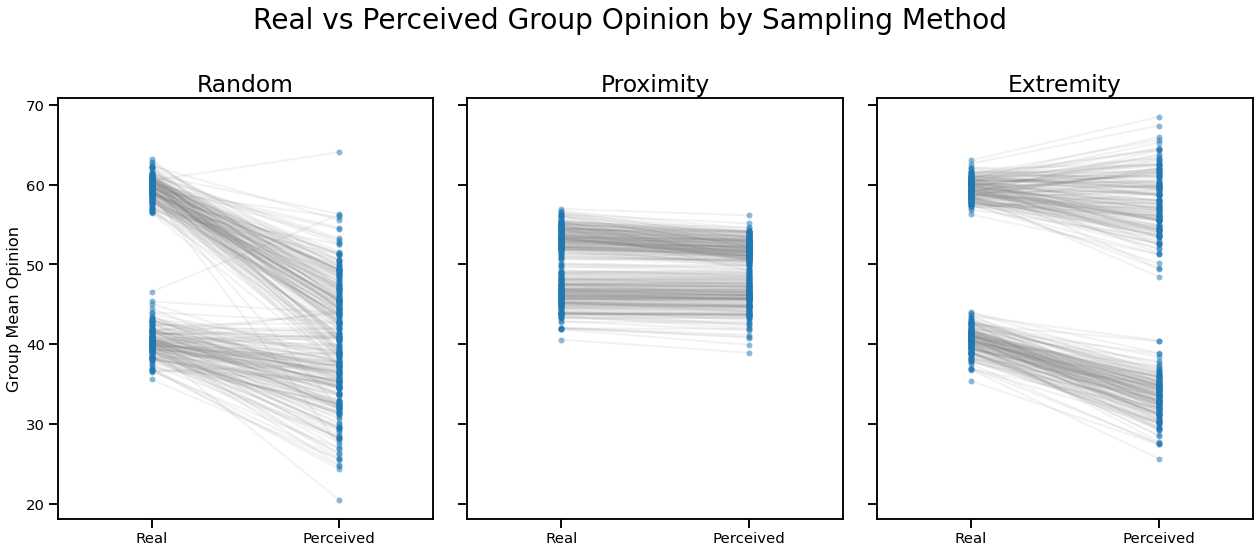

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_long = df.melt(
    id_vars=["simnum", "GroupID", "sample_method"],
    value_vars=["true_mean", "percept_fin"],
    var_name="Type",
    value_name="MeanValue"
)

df_long["Type"] = df_long["Type"].map({
    "true_mean": "Real",
    "percept_fin": "Perceived"
})

methods = ["random", "proximity", "extremity"]
order = ["Real", "Perceived"]

fig, axes = plt.subplots(1, len(methods), figsize=(18, 8), sharey=True)
fig.subplots_adjust(wspace=0.15)

for ax, method in zip(axes, methods):
    
    df_sub = df_long[df_long["sample_method"] == method]
    
    # Connecting lines
    for (sim, group), subdf in df_sub.groupby(["simnum", "GroupID"]):
        subdf = subdf.set_index("Type").loc[order].reset_index()
        ax.plot(
            subdf["Type"],
            subdf["MeanValue"],
            color="gray",
            alpha=0.1,
            linewidth=2
        )

    # Overlay dots
    sns.stripplot(
        data=df_sub,
        x="Type",
        y="MeanValue",
        order=order,
        jitter=0,
        alpha=0.5,
        marker=".",
        size=12,
        ax=ax
    )
    sns.set_context("talk", font_scale=1.3)

    ax.set_title(method.capitalize())
    ax.set_xlabel("")
    ax.set_ylabel("Group Mean Opinion")

plt.suptitle("Real vs Perceived Group Opinion by Sampling Method")
plt.tight_layout()

plt.savefig("figure1_v1.pdf", format="pdf", bbox_inches="tight")
plt.show()

## 3x3 version

In [11]:
df.head()

,simnum,init_type,temp,sample_method,aAmp,aWidth,rAmp,rWidth,GroupID,true_mean,true_var,group_size_init,group_size_fin,percept_init,percept_fin,percept_outgroup_fin,rank_within_sim,pole,pole_sign,signed_discrepancy
0,228308,initgauss,100,random,0.2,4.0,1.0,4.0,0,39.489085,734.435428,527,512,45.741601,32.911238,68.476179,1.0,low,-1,6.577847
1,228308,initgauss,100,random,0.2,4.0,1.0,4.0,1,62.301611,715.292259,473,488,53.854217,44.532558,45.359701,2.0,high,1,-17.769053
2,228319,initgauss,100,random,0.2,4.0,1.0,4.0,0,42.462676,712.064740,497,544,46.167679,41.378345,64.824425,1.0,low,-1,1.084331
3,228319,initgauss,100,random,0.2,4.0,1.0,4.0,1,57.704693,797.436736,503,456,53.373132,48.733544,51.908771,2.0,high,1,-8.971149
4,228313,initgauss,100,random,0.2,4.0,1.0,4.0,0,39.245617,774.315788,504,509,45.574900,38.676463,65.917636,1.0,low,-1,0.569154


/tmp/ipykernel_1836428/3612140572.py:105: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
/tmp/ipykernel_1836428/3612140572.py:105: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
/tmp/ipykernel_1836428/3612140572.py:105: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
/tmp/ipykernel_1836428/3612140572.py:105: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax

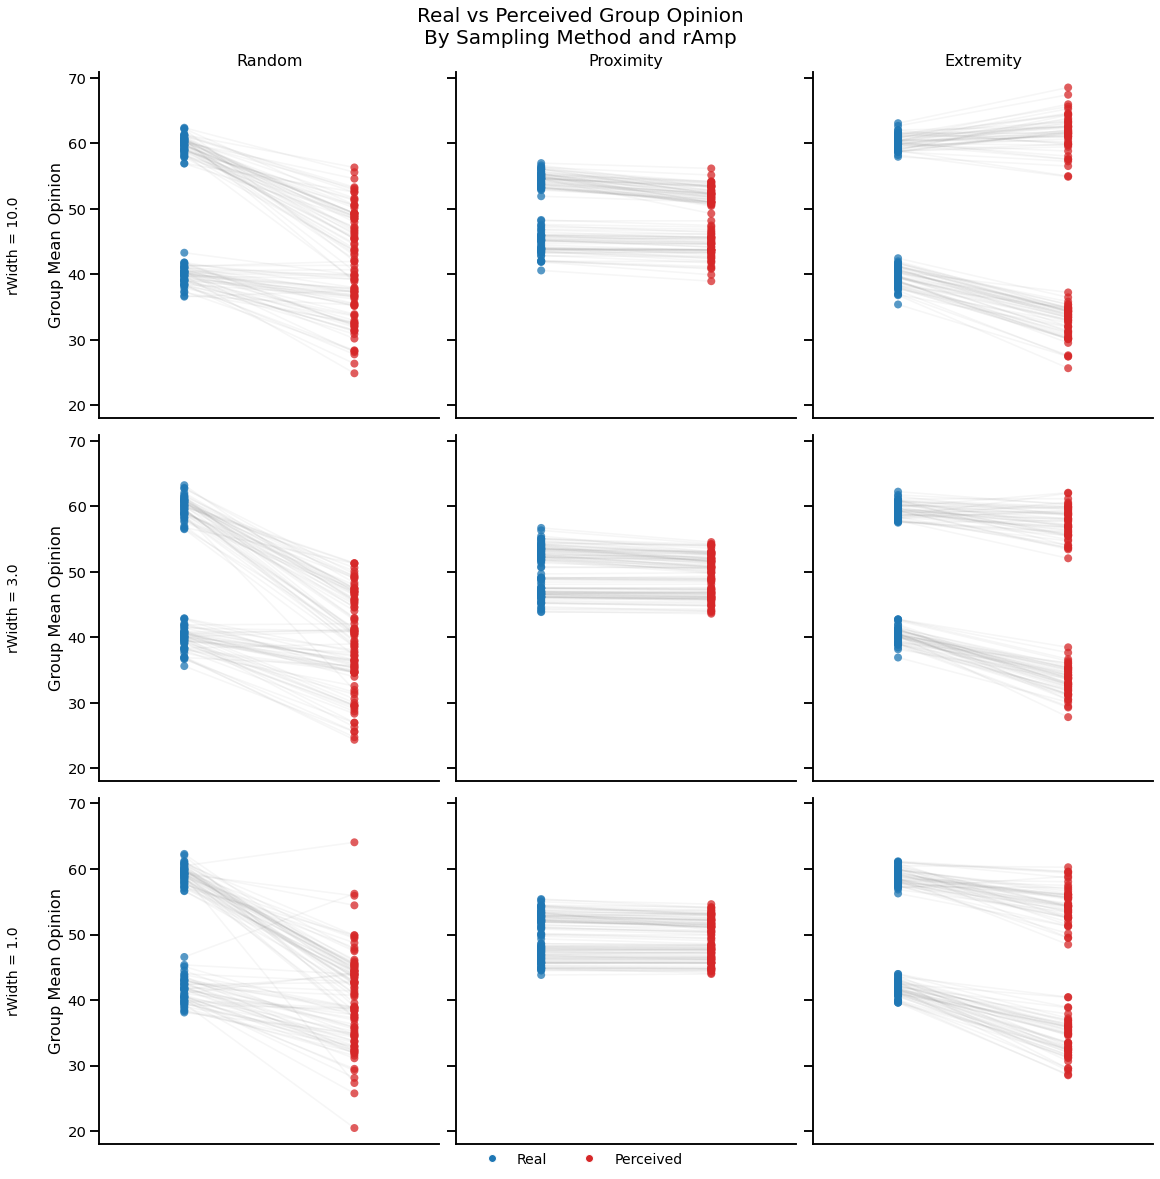

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------- Reshape ----------
df_long = df.melt(
    id_vars=["simnum", "GroupID", "sample_method", "rAmp"],
    value_vars=["true_mean", "percept_fin"],
    var_name="Type",
    value_name="MeanValue"
)

df_long["Type"] = df_long["Type"].map({
    "true_mean": "Real",
    "percept_fin": "Perceived"
})

methods = ["random", "proximity", "extremity"]
rAmps = [10.0, 3.0, 1.0]   # top → bottom
order = ["Real", "Perceived"]

palette = {
    "Real": "#1f77b4",
    "Perceived": "#d62728"
}

sns.set_context("talk", font_scale=0.9)

# ---------- Create Figure ----------
fig, axes = plt.subplots(
    nrows=len(rAmps),
    ncols=len(methods),
    figsize=(16, 16),
    sharey=True,
    constrained_layout=True
)

# Remove internal spacing
fig.set_constrained_layout_pads(
    w_pad=0.0,
    h_pad=0.0,
    wspace=0.0,
    hspace=0.0
)

# ---------- Plot Loop ----------
for i, r in enumerate(rAmps):
    for j, method in enumerate(methods):

        ax = axes[i, j]

        df_sub = df_long[
            (df_long["sample_method"] == method) &
            (df_long["rAmp"] == r)
        ]

        # Paired connecting lines
        for (sim, group), subdf in df_sub.groupby(["simnum", "GroupID"]):
            subdf = subdf.set_index("Type").loc[order].reset_index()
            ax.plot(
                subdf["Type"],
                subdf["MeanValue"],
                color="gray",
                alpha=0.07,
                linewidth=1.6,
                zorder=1
            )

        # Colored points
        sns.stripplot(
            data=df_sub,
            x="Type",
            y="MeanValue",
            order=order,
            hue="Type",
            palette=palette,
            dodge=False,
            jitter=0,
            alpha=0.75,
            marker=".",
            size=16,
            ax=ax,
            legend=False,
            zorder=2
        )

        # Column titles (top row only)
        if i == 0:
            ax.set_title(method.capitalize(), fontsize=16)

        # Row labels (left column only)
        if j == 0:
            ax.text(
                -0.25, 0.5,
                f"rWidth = {r}",
                rotation=90,
                va="center",
                ha="center",
                transform=ax.transAxes,
                fontsize=14
            )

        # Remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xlabel("")

        # Clean spines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Remove redundant y-labels
        if j != 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("Group Mean Opinion")

# ---------- Shared Legend ----------
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=palette["Real"],
               markersize=8, label="Real"),
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=palette["Perceived"],
               markersize=8, label="Perceived")
]

fig.legend(
    handles=handles,
    loc="lower center",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, -0.02),
    fontsize=14
)

# ---------- Title ----------
fig.suptitle(
    "Real vs Perceived Group Opinion\nBy Sampling Method and rAmp",
    fontsize=20
)

plt.savefig("figure1_3x3.pdf", format="pdf", bbox_inches="tight")
plt.show()

## False polarization plot

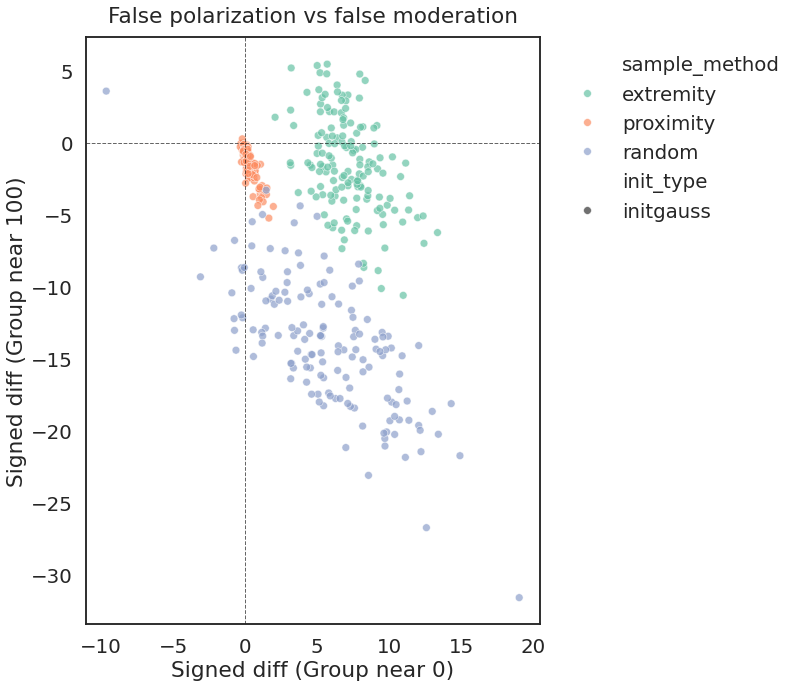

In [17]:
df_scatter = (
    df
    .set_index(["init_type", "sample_method", "simnum", "pole"])
    ["signed_discrepancy"]
    .unstack("pole")
    .reset_index()
    .rename(columns={
        "low": "low_group_discrepancy",
        "high": "high_group_discrepancy"
    })
)

sns.set_context("talk", font_scale=1.2)
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10, 10))

ax.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.6)
ax.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.6)

sns.scatterplot(
    data=df_scatter,
    x="low_group_discrepancy",
    y="high_group_discrepancy",
    hue="sample_method",
    style="init_type",
    alpha=0.7,
    s=60,
    palette="Set2",
    ax=ax
)

ax.set_title("False polarization vs false moderation", pad=15)
ax.set_xlabel("Signed diff (Group near 0)")
ax.set_ylabel("Signed diff (Group near 100)")

ax.set_aspect("equal", adjustable="box")

ax.legend(
    title=None,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

fig.tight_layout()
fig.subplots_adjust(right=0.8)

plt.savefig("figure_falsepol_v3.pdf", format="pdf", bbox_inches="tight")
plt.show()